In [1]:
import openmc
import numpy as np

In [2]:
BISO_KERNEL_RADIUS   = 0.04 # cm  # r = 400 μm = 0.0400 cm // "800 μm kernel"
BISO_RADIUS          = 0.05 # cm  # r = 500 μm = 0.0500 cm // "100 μm thickness"
BISO_VOLUME          = (4 / 3) * np.pi * (BISO_RADIUS)**3            # volume of single BISO particle
KERNEL_VOLUME        = (4 / 3) * np.pi * (BISO_KERNEL_RADIUS)**3     # volume of UO2/ThO2 kernel in single BISO particle
BISO_KERNEL_VOL_FRAC = KERNEL_VOLUME / BISO_VOLUME  # vol frac kernel in single BISO
BISO_COAT_VOL_FRAC   = 1.0 - BISO_KERNEL_VOL_FRAC

In [3]:
# UO2 fuel kernel
uo2 = openmc.Material(name='UO2', temperature=900)
uo2.add_element('U', 1.0, enrichment=0.71)  
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.5)

# SiC coating
sic = openmc.Material(name='SiC', temperature=900)
sic.add_element('Si', 1.0)
sic.add_element('C', 1.0)
sic.set_density('g/cm3', 3.2)

# Lead-Lithium (Pb83at%-Li17at%)
pbli = openmc.Material(name='PbLi', temperature=900)
pbli.add_element('Pb', 0.83)
pbli.add_element('Li', 0.1, enrichment_target='Li6', enrichment_type='wo', enrichment=90.0)
pbli.set_density('g/cm3', 9.5) 

# BISO
biso = openmc.Material.mix_materials([uo2, sic], [BISO_KERNEL_VOL_FRAC, BISO_COAT_VOL_FRAC], 'vo')
mix  = openmc.Material.mix_materials([pbli, biso], [0.99, 0.01], 'vo')

materials = openmc.Materials([uo2, sic, pbli, biso, mix])
materials.cross_sections = '/mnt/c/OpenMC/data/endfb-viii.0-hdf5/cross_sections.xml'
# materials.export_to_xml()

In [4]:
# Reflective cube boundaries 
cube_length = 1  # cm
cube_half   = cube_length / 2

x_min = openmc.XPlane(-cube_half, boundary_type='periodic')
x_max = openmc.XPlane( cube_half, boundary_type='periodic')
y_min = openmc.YPlane(-cube_half, boundary_type='periodic')
y_max = openmc.YPlane( cube_half, boundary_type='periodic')
z_min = openmc.ZPlane(-cube_half, boundary_type='periodic')
z_max = openmc.ZPlane( cube_half, boundary_type='periodic')
x_min.periodic_surface = x_max
y_min.periodic_surface = y_max
z_min.periodic_surface = z_max

# Homogeneous matrix
cell = openmc.Cell(name='mixture')
cell.fill = mix
cell.region = +x_min & -x_max & +y_min & -y_max & +z_min & -z_max

# Create universe and geometry
root_universe = openmc.Universe(cells=[cell])
geometry = openmc.Geometry(root_universe)
# geometry.export_to_xml()

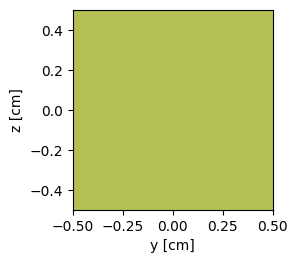

In [5]:
img = geometry.plot(basis='yz',                           # slice plane
                    width=(cube_length, cube_length),     # cm window
                    pixels=(200, 200),
                    color_by='material')

In [8]:
settings = openmc.Settings()

"""Source: 14 MeV"""
eps = 1e-8
source = openmc.IndependentSource()
source.space = openmc.stats.Box((-cube_half,-cube_half,-cube_half),
                                ( cube_half, cube_half, cube_half),
                                 only_fissionable=False) # openmc.stats.Point((-cube_half+eps,-cube_half+eps,-cube_half+eps))
source.particle = 'neutron'
source.energy   = openmc.stats.Discrete([14.0e6], [1.0])  # 14 MeV
# source.angle    = openmc.stats.Monodirectional((0, 0, 1))

"""Settings"""
settings = openmc.Settings()
settings.run_mode  = "fixed source"
settings.batches   = 10
settings.particles = int(1e5)
settings.sources   = [source]
settings.write_initial_source = True

In [9]:
"""Tallies"""
tallies = openmc.Tallies()

# total rxn rates
t_tot = openmc.Tally(name="total rxn rates")
t_tot.scores = ["absorption", "fission", "(n,gamma)", "(n,Xt)"]
tallies.append(t_tot)

In [10]:
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./BISO_LL_homogeneous")
model.run(cwd="./BISO_LL_homogeneous") 

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/mnt/c/MCNP/emma-openmc/Jupyter/BISO_LL_homogeneous/statepoint.10.h5')

[9.35240253e-09 9.30660156e-09 3.91729581e-08 ... 1.14630625e-08
 1.24188294e-08 3.19478265e-09]


ValueError: x and y must have same first dimension, but have shapes (100,) and (1000000,)

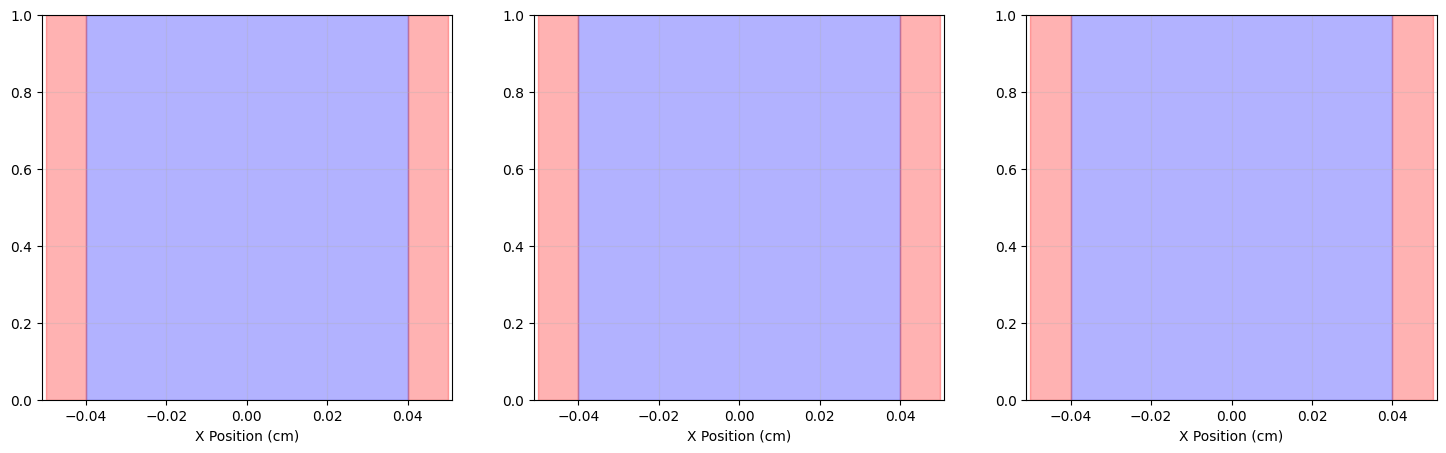

In [15]:
import matplotlib.pyplot as plt

with openmc.StatePoint('statepoint.10.h5') as sp:
    df_ng   = sp.get_tally(name='(n,gamma) by cell').get_pandas_dataframe()
    df_fis  = sp.get_tally(name='(n,fis) by cell').get_pandas_dataframe()
    df_abs  = sp.get_tally(name='(n,abs) by cell').get_pandas_dataframe()

Li6_nt = Li[(Li['nuclide']=='Li6') & (Li['score']=='(n,Xt)')][['cell','score','mean','std. dev.']]
Li6_nt_list     = Li6_nt['mean'].tolist()

# Mesh coordinates
x_min, x_max = mesh.lower_left[0], mesh.upper_right[0]
nx = 100
x_positions = np.linspace(x_min, x_max, nx + 1)
x_centers = (x_positions[:-1] + x_positions[1:]) / 2

# --- Multi-panel plot setup ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Define common shaded regions for materials
for ax in axes:
    ax.axvspan(-0.04, 0.04, alpha=0.3, color='blue', label='UO$_2$ kernel')
    ax.axvspan(0.04, 0.05, alpha=0.3, color='red', label='SiC shell')
    ax.axvspan(-0.05, -0.04, alpha=0.3, color='red')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel('X Position (cm)')

# --- Plot each quantity separately ---
axes[0].plot(x_centers, flux_mean, '-', lw=1.2, color='black')
axes[0].set_title('Neutron Flux')
axes[0].set_ylabel('Flux (n/cm$^2$/source)')

axes[1].plot(x_centers, ng_mean, '-', lw=1.2, color='green')
axes[1].set_title('(n,γ) Reaction Rate')

axes[2].plot(x_centers, total_mean, '-', lw=1.2, color='orange')
axes[2].set_title('Total Reaction Rate')

# Common legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Optionally save
# fig.savefig('flux_profiles_side_by_side.png', dpi=150, bbox_inches='tight')